# Active Learning with API



## Import

In [1]:
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import copy
import math

from scipy.interpolate import interp1d
import torch

os.chdir(os.path.dirname(os.getcwd()))
from Settings import Directory, Plotting_Parameters
from DataReader import DataReader
from DNN import DNN
from Plot_Functions import plot_MV_interaction
from Plot_Functions import find_similar_profiles

import warnings
warnings.filterwarnings('ignore')

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [2]:
plot_params = Plotting_Parameters()
directory = Directory()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [3]:
datareader = DataReader()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
extended_profiles_iter_1.csv
extended_profiles_iter_2.csv
extended_profiles_iter_3.csv
extenden_profiles_iter_1.csv
extenden_profiles_iter_2.csv
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx


## Load Data

In [4]:
df_full = datareader.load('Knee_Connection_Output_red.csv')

Knee_Connection_Output_red.csv: (714385, 53)


## Load Forward Model

In [5]:
model = DNN()

model_name = "DNN_Model_Full_V2"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")
                               
model = torch.load(MODEL_SAVE_FILE)
df = df_full.loc[model.data['data_indeces']]

for key, value in model.config.items():
    print(key, value)

batch_size 256
epochs 3000
learning_rate 0.001
test_size 0.1
val_size 0.1
print_logs True
dropout_prob 0.0
num_layers 3
neurons_per_layer [128, 64, 32, 16, 8]
use_batch_norm True
seed 42
description Use larger network architecture and more features as training data. Also use Batch normalization


## Generate (or load) data uncertainties

### Generate

In [6]:
#mcd_mean_full, mcd_std_full, _ = model.mc_dropout_uncertainty(df_full, num_samples=200)

In [7]:
#uncertainty_full = mcd_std_full / mcd_mean_full
#np.save(r"Saved Variables\uncertainty_fulldf.npy", uncertainty_full)

### Load

In [8]:
uncertainty_full = np.load(r"Saved Variables\uncertainty_fulldf.npy").flatten()

## Illustrate workflow

### 1. Find most uncertain profiles

In [9]:
most_uncertain_samples = np.argsort(uncertainty_full)[-10:]
df_most_uncertain = df_full.loc[most_uncertain_samples]

In [10]:
y_preds, _ = model.predict(df_full)
y_truths = df_full['target'].values

In [11]:
rel_error = (y_truths-y_preds.numpy().flatten())/ y_truths

In [12]:
most_error_samples = np.argsort(np.abs(rel_error))[-10:]
df_most_error = df_full.loc[most_error_samples]

In [13]:
uncertainty_full = rel_error

Define geometric & material features, which define a profile. (No loads)

In [14]:
fixed_features = model.features.copy()
fixed_features.remove('M_contribution')
fixed_features.remove('V_contribution')

Taking the most uncertain values is not a good strategy, since most of them will be from the same profile (different load combinations).

In [15]:
df_most_uncertain[fixed_features].duplicated(keep=False)

71617     True
71615     True
71965    False
71619     True
71553    False
74197     True
71616     True
74199     True
71618     True
71879    False
dtype: bool

Instead form groups according to the profile dimensions (identical geometry/material, different load combinations).

In [16]:
identical_groups = df[fixed_features].groupby(list(df[fixed_features].columns)).apply(lambda x: x.index.tolist()).tolist()
print(f"Number of identical groups: {len(identical_groups)}")

Number of identical groups: 152259


Get the max uncertainty for each group:

In [17]:
group_uncertainty = np.array([uncertainty_full[group].max() for group in identical_groups])

Get the n most uncertain groups:

In [18]:
most_uncertain_groups = np.argsort(group_uncertainty)[-10:]

Most uncertain group of profiles:

In [19]:
most_uncertain_group_ids = identical_groups[most_uncertain_groups[0]]

Select one profile of the group to serve as a template (does not matter which, since all have identical features):

In [20]:
base_id = most_uncertain_group_ids[0]

base_profile = df_full.iloc[base_id:base_id+1].copy()
group_profiles = df_full.iloc[most_uncertain_group_ids].copy()
group_uncertainty = uncertainty_full[most_uncertain_group_ids]

### 2. Get new load combination

Function to find the location (M/V contribution) of new load combinations, based on the location and uncertainty of existing points.

In [21]:
def find_optimal_location(V_cont, uncertainty):
    angles = np.arcsin(V_cont) / (np.pi / 2)
    if uncertainty.max() - uncertainty.min() == 0:
        uncertainty_normalized = (uncertainty - uncertainty.min())
    else:
        uncertainty_normalized = (uncertainty - uncertainty.min()) / (uncertainty.max() - uncertainty.min())

    sorted_indices = np.argsort(angles)
    angles_sorted = angles[sorted_indices]
    uncertainty_sorted = uncertainty_normalized[sorted_indices]

    if 0 not in angles_sorted:
        angles_sorted = np.insert(angles_sorted, 0, 0)
        uncertainty_sorted = np.insert(uncertainty_sorted, 0, uncertainty_sorted[0])

    if 1 not in angles_sorted:
        angles_sorted = np.append(angles_sorted, 1)
        uncertainty_sorted = np.append(uncertainty_sorted, uncertainty_sorted[-1])

    interp_func = interp1d(angles_sorted, uncertainty_sorted, kind='linear')
    x = np.linspace(0, 1, 100)
    uncertainty_interpolated = interp_func(x)

    min_distance = lambda new_point, existing_points: np.min(np.abs(existing_points - new_point))
    distance_penalty = np.array([min_distance(xi, angles[sorted_indices]) for xi in x])
    objective = uncertainty_interpolated * distance_penalty

    return x[np.argmax(objective)]

def get_MV_contribution(ratio):
    M_contribution = np.cos(ratio * (np.pi / 2))
    V_contribution = np.sin(ratio * (np.pi / 2))
    M_contribution = round(M_contribution, 12)
    V_contribution = round(V_contribution, 12)
    return M_contribution, V_contribution

In [22]:
ratio = find_optimal_location(group_profiles['V_contribution'].values, group_uncertainty) # M or V needed?
M_contribution, V_contribution = get_MV_contribution(ratio)

new_profile = base_profile.copy()
new_profile['M_contribution'] = round(M_contribution,6)
new_profile['V_contribution'] = round(V_contribution,6)

print(f"Optimal ratio: {ratio}")
print(f"Optimal M_contribution: {M_contribution}")
print(f"Optimal V_contribution: {V_contribution}")

Optimal ratio: 0.48484848484848486
Optimal M_contribution: 0.723734038105
Optimal V_contribution: 0.690079011482


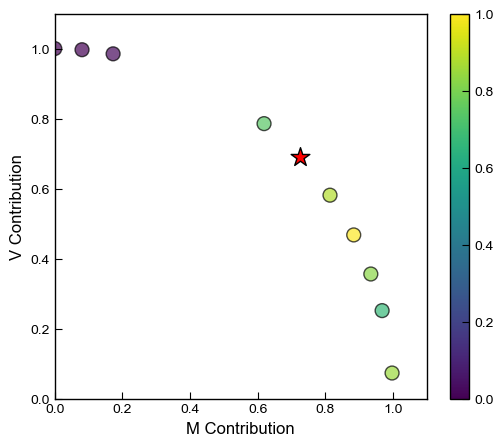

In [23]:
fig, ax = plt.subplots(figsize=(6,5))

plt.scatter(group_profiles['M_contribution'], group_profiles['V_contribution'],
            c=group_uncertainty, cmap='viridis', s=100, edgecolor='black', alpha=0.7)

plt.scatter(new_profile['M_contribution'], new_profile['V_contribution'],
            c='red', s=200, edgecolor='black', label='New Profile', marker='*')

plt.xlabel('M Contribution')
plt.ylabel('V Contribution')
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)

plt.colorbar()

plt.show()

In [24]:
current_id = len(df_full)

new_profile.index = [current_id]
new_profile['M_Rd'] = None
new_profile['V_Rd'] = None
new_profile['M'] = None
new_profile['V'] = None
new_profile['proz'] = None

This is the resulting profile. The geometric and material features are taken from the base profile (template), only the load combination is novel. 

In [25]:
new_profile

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,M_Rd,V_Rd,V_contribution,M_contribution,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost
714385,HEA140,133,140,5.5,8.5,3141.610658,1012.360658,10330000,155400.0,173500,...,None,None,0.690079,0.723734,0.049662,0.678079,0.679895,0,1,NaN


### 3. Calculate Resistance with API

In [26]:
os.chdir(r"AL_API")
from API import IdeaConnectionClient

Absolute Paths are needed.

In [27]:
PATH = os.path.join(directory.root, "AL_API")
InputFileName = os.path.join(PATH,"Knee_widener_I_Output_red_Q4.parquet")

There are four idea templates. Depending on the existence of certain features, different templates have to be chosen. Depending on the lowest nonzero feature (see image), the according template is chosen.

<img src="templates.png" alt="image" width="600"/>

In [106]:
# All template names
ideatemplates_filenames = ['Corner.ideaCon',
                        'Corner_Stiffner.ideaCon',
                        'Corner_Stiff_Wid.ideaCon',
                        'Corner_Stiff2_Wid.ideaCon']

# Features that vary across templates
variable_features = ['t_stiffc',
                'h_wid',
                'b_wid',
                'd_wid',
                't_fwid',
                't_wwid',
                't_stiffb'
                ]

# How many variables each template has (e.g. Corner is the most simplest template and has 0 variable features)
existing_variable_features = {'Corner.ideaCon':0,
                              'Corner_Stiffner.ideaCon':1,
                              'Corner_Stiff_Wid.ideaCon':6,
                              'Corner_Stiff2_Wid.ideaCon':7}

existing_variable_features_indices = np.array(list(existing_variable_features.values()))

# Function to retrieve the ideal template based on the profile
def get_ideatemplate(profile):
    values = profile[variable_features].fillna(0).astype(float).values
    nonzero_indices = np.nonzero(values)[0]
    highest_nonzero_index = 0 if len(nonzero_indices) == 0 else np.max(nonzero_indices) + 1
    ideatemplate_id = np.nanargmin(np.abs(existing_variable_features_indices - highest_nonzero_index))
    return ideatemplates_filenames[ideatemplate_id]

Find the template for the considered profile and open it in IdeaStatica.

In [113]:
inputs = new_profile.copy()
ideatemplate = get_ideatemplate(inputs)
IdeaName = os.path.join(PATH,ideatemplate)

conn = IdeaConnectionClient()
conn.open(IdeaName)

c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks\AL_API\Corner_Stiffner.ideaCon


### 4. Prepare

Adjust the feature labeling and the unit scaling to match with IdeaStatica.

In [114]:
i=inputs.index[0]  
params = {
    'Prof_c': inputs.at[i, 'Profile_x'], 'Prof_b': inputs.at[i, 'Profile_y'],
    'steel_grade': inputs.at[i, 'Steel grade_x'], 'gamma': inputs.at[i, 'Gamma'], 
    'h_wid': inputs.at[i, 'h_wid']/1000, 'b_wid': inputs.at[i, 'b_wid']/1000,
    'd_wid': inputs.at[i, 'd_wid']/1000, 't_fwid': inputs.at[i, 't_fwid']/1000,
    't_wwid': inputs.at[i, 't_wwid']/1000, 
    't_stiffc': inputs.at[i, 't_stiffc']/1000, 't_stiffb': inputs.at[i, 't_stiffb']/1000,
    'offset': inputs.at[i, 'Offset']/1000  
}

Load parameters into IdeaStatice to build the profile.

In [115]:
conn.update_params_by_name(params)
if not conn.params_valid():
    raise Exception("Parameters validation failed.")

#### 5. Define Loads

Set initial loads based on moment and shear plastic capacity and on calculated moment and shear distribution. It is an initial guess.

In [ ]:
inputs['Mmax'] = inputs[['Mpl_x', 'Mpl_y']].max(axis=1)
inputs['Vmax'] = inputs[['Vpl_x', 'Vpl_y']].max(axis=1)
print(inputs['Mmax'].values)
print(inputs['Vmax'].values)
inputs['M'] = inputs['M_contribution'] * inputs['Mmax']
inputs['V'] = inputs['V_contribution'] * inputs['Vmax']
print(inputs['M'].values)
print(inputs['V'].values)

inputs = inputs.drop(columns=['Mmax','Vmax'])

[47.7125]
[174.03094043]
[34.53115847]
[120.09509734]


Functions to adjust loads incrementely up (underloaded) or down (overloaded).

In [ ]:
def overloaded(calculated,profiles,i):
    k=0
    while calculated == False:
        print('k =', k)
        loads = conn.get_loads()
        if profiles.at[i,'M']==0:
            profiles.at[i,'V']*=0.9
        elif profiles.at[i,'V']==0:
            profiles.at[i,'M']*=0.9
        else:
            alpha = math.atan(profiles.at[i,'V']/profiles.at[i,'M'])
            r = (profiles.at[i,'M']**2+profiles.at[i,'V']**2)**0.5
            r*=0.9
            profiles.at[i,'M'] = r*math.cos(alpha)
            profiles.at[i,'V'] = r*math.sin(alpha)
        loads[0]['forcesOnSegments'][1]['my'] = int(profiles.at[i,'M']*1000)
        loads[0]['forcesOnSegments'][1]['qz'] = int(profiles.at[i,'V']*1000) #!!!!
        conn.set_loads(loads)
        print('M=',loads[0]['forcesOnSegments'][1]['my'] )
        print('V=',loads[0]['forcesOnSegments'][1]['qz'] ) 
        calculated = conn.calculate()
        k=(k+1)
        if k == 100:
            break
        
# In case of underload,, get in the loop and decrease the load:
def underloaded(applied_percentage,profiles,i):
    j=0
    while applied_percentage == 1:
        print('j =', j)
        print('Applied percentage =',applied_percentage)
        loads = conn.get_loads()
        if profiles.at[i,'M']==0:
            profiles.at[i,'V']*=1.1
        elif profiles.at[i,'V']==0:
            profiles.at[i,'M']*=1.1
        else:    
            alpha = math.atan(profiles.at[i,'V']/profiles.at[i,'M'])
            r = (profiles.at[i,'M']**2+profiles.at[i,'V']**2)**0.5
            r*=1.3
            profiles.at[i,'M'] = r*math.cos(alpha)
            profiles.at[i,'V'] = r*math.sin(alpha)
        loads[0]['forcesOnSegments'][1]['my'] = int(profiles.at[i,'M']*1000)
        loads[0]['forcesOnSegments'][1]['qz'] = int(profiles.at[i,'V']*1000) #!!!!
        conn.set_loads(loads)
        print('M=',loads[0]['forcesOnSegments'][1]['my'] )
        print('V=',loads[0]['forcesOnSegments'][1]['qz'] )    
        calculated = conn.calculate()
        if calculated == False:
            overloaded(calculated,profiles,i)
        
        # Get the applied loads:
        results = conn.get_results()
        loads = conn.get_loads()
        applied_percentage = results['analysis']['1']['appliedLoadPercentage']
        j=(j+1)

In [ ]:
loads = conn.get_loads()

loads[0]['forcesOnSegments'][1]['my'] = int(inputs.at[i,'M']*1000)
loads[0]['forcesOnSegments'][1]['qz'] = int(inputs.at[i,'V']*1000)#!!!!

conn.set_loads(loads) 
print('M=',loads[0]['forcesOnSegments'][1]['my'] )
print('V=',loads[0]['forcesOnSegments'][1]['qz'] )            

M= 34531
V= 120095


In [ ]:
new_profile['M'] = inputs['M'].values[0]
new_profile['V'] = inputs['V'].values[0]

### 6. Calculate

Calculate ...

In [ ]:
calculated = conn.calculate()

if calculated == False:
    overloaded(calculated, new_profile, new_profile.index[0])

Get results:

In [ ]:
results = conn.get_results()
loads = conn.get_loads()
applied_percentage = results['analysis']['1']['appliedLoadPercentage']   
if applied_percentage == 1:
    underloaded(applied_percentage,new_profile,new_profile.index[0])

applied_M = applied_percentage * loads[0]['forcesOnSegments'][1]['my']
applied_V = applied_percentage * loads[0]['forcesOnSegments'][1]['qz']

outputs = inputs.copy()

outputs.at[i, 'proz'] = applied_percentage
outputs.at[i, 'M_Rd'] = applied_M/1000 # [kNm]
outputs.at[i, 'V_Rd'] = applied_V/1000 # [kN]

cost = results['costEstimationResults']['totalEstimatedCost']
outputs.at[i, 'cost'] = cost

Final profile with calculate moment and shear resistance.

In [ ]:
outputs

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,M_Rd,V_Rd,V_contribution,M_contribution,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost
714385,HEA140,133,140,5.5,8.5,3141.610658,1012.360658,10330000,155400.0,173500,...,23.335402,81.157949,0.690079,0.723734,0.049662,0.678079,0.679895,0,1,125.573642


Calculate the target value from the resulting moment and shear resistance.

In [ ]:
def calculate_target_from_Rd(profile):
    profile['V_norm'] = abs(profile['V_Rd'] / profile['Vpl_y'])
    profile['M_norm'] = abs(profile['M_Rd'] / profile['Mpl_y'])
    profile['target'] = (profile['V_norm']**2 + profile['M_norm']**2)**0.5

In [ ]:
calculate_target_from_Rd(outputs)

In [ ]:
conn.close()

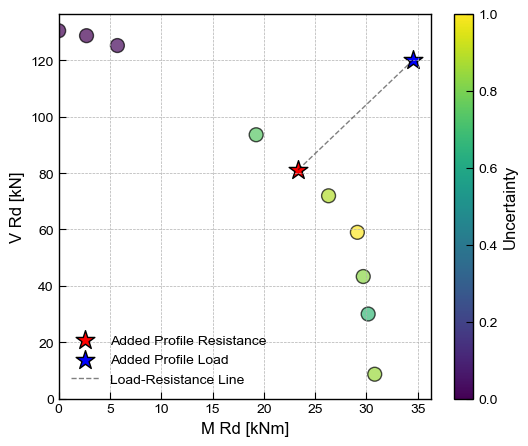

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))

plt.scatter(df_full.loc[most_uncertain_group_ids]['M_Rd'].values,
            df_full.loc[most_uncertain_group_ids]['V_Rd'].values,
            c=group_uncertainty, cmap='viridis', s=100, edgecolor='black', alpha=0.7)

plt.scatter(outputs['M_Rd'].values,
            outputs['V_Rd'].values,
            c='red', s=200, edgecolor='black', label='Added Profile Resistance', marker='*')

plt.scatter(outputs['M'],
            outputs['V'],
            c='blue', s=200, edgecolor='black', label='Added Profile Load', marker='*')

plt.plot((outputs['M_Rd'].values, outputs['M'].values),(outputs['V_Rd'].values, outputs['V'].values),
         color='black', linestyle='--', linewidth=1, alpha=0.5, label='Load-Resistance Line')

plt.xlabel('M Rd [kNm]')
plt.ylabel('V Rd [kN]')

plt.legend()
plt.colorbar(label='Uncertainty')
plt.xlim(0, None)
plt.ylim(0, None)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

## Local Active Learning

Key Factors to Consider
New Data Significance: The new samples are hard cases (high-error), so they often carry higher informational value per sample than random ones.

Overfitting Risk: Since you're adding ~0.2% more data each round (1000 out of 500,000), doing too many epochs on just that subset risks overfitting or unbalancing the model.

Model Retention vs. Adaptation: You don’t want the model to "forget" prior knowledge or overcorrect on edge cases.

Why Retrain from Scratch After Active Learning?
✅ Avoids Bias from Sequential Fine-Tuning
Fine-tuning in each AL step introduces a form of path dependency: each update is conditioned on the previous model state, which might lead to suboptimal local minima or accumulation of small biases. Retraining allows the model to learn a more globally optimal representation from the entire distribution, now better represented with informative samples.

✅ Better Generalization
With all the high-value samples added, retraining gives the model the opportunity to reorganize its internal representations for improved generalization across both original and hard (AL) data.

✅ Clean Training Dynamics
Fine-tuning can introduce artifacts like:

Unbalanced weight updates

Overfitting to recent samples

Hidden dependencies on prior model states

Starting from scratch with a well-prepared, enriched dataset allows for cleaner convergence and typically results in better final performance.



In [139]:
model_AL = copy.deepcopy(model)
df_AL = df_full.copy()

In [140]:
#identical_groups = df_AL[fixed_features].groupby(list(df_AL[fixed_features].columns)).apply(lambda x: x.index.tolist()).tolist()
# Initialize a Series to store group IDs
df_AL['group_id'] = df_AL[fixed_features].groupby(fixed_features).ngroup()
identical_groups = df_AL.groupby('group_id').apply(lambda x: x.index.tolist()).tolist()

In [141]:
iterations = 3
groups_per_iter = 1000
add_per_group = 3

finetuning_lr = model.config['learning_rate']
patience = 3

print(f"Added Samples per iteration: {groups_per_iter * add_per_group}")
print(f"Added Samples: {iterations * groups_per_iter * add_per_group}")

Added Samples per iteration: 3000
Added Samples: 9000


In [142]:
epoch_per_data_ratio = model_AL.config['epochs'] / len(model_AL.data['data_indeces'])
print(f"Epochs per data ratio: {epoch_per_data_ratio}")

Epochs per data ratio: 0.004199416281136922


In [143]:
epochs_per_iter = max(int(epoch_per_data_ratio * groups_per_iter * add_per_group) * 10, 5)
print(f"Epochs per iteration: {epochs_per_iter}")
print(f"Total Epochs: {iterations * epochs_per_iter}")

Epochs per iteration: 120
Total Epochs: 360


In [144]:
save = True

### Loop

In [ ]:
for iter in range(iterations):
    print(f"*** Iteration {iter+1}/{iterations} ***")
    current_id = len(df_AL)
    # Get the most uncertain samples
    print('Get Uncertainties')
    
    #mcd_mean, mcd_std, _ = model_AL.mc_dropout_uncertainty(df_AL, num_samples=100)
    #uncertainty = mcd_std / mcd_mean

    y_preds, _ = model_AL.predict(df_AL)
    y_preds = y_preds.numpy().flatten()
    y_truth = df_AL['target'].values
    rel_error = np.abs((y_preds - y_truth) / y_truth+1e-8)
    uncertainty = rel_error

    uncertainty_per_group = np.array([uncertainty[group].max() for group in identical_groups])
    most_uncertain_groups = np.argsort(uncertainty_per_group)[-groups_per_iter:]

    df_new_profiles = pd.DataFrame(columns=df_AL.columns)

    for i, group_id in enumerate(most_uncertain_groups):
        print(f"   Processing Group {i/len(most_uncertain_groups):.2%} (Group id: {group_id})")

        group = np.array(identical_groups[group_id])
        df_group = df_AL.loc[group].copy()
        
        base_id = identical_groups[group_id][0]
        identical_groups[group_id].extend(np.arange(current_id, current_id + add_per_group))

        base_profile = df_AL.iloc[base_id:base_id+1].copy()
        base_profile['M_Rd'] = None
        base_profile['V_Rd'] = None
        base_profile['M'] = None
        base_profile['V'] = None
        base_profile['proz'] = None
        base_profile['base_sample_id'] = int(base_id)
        base_profile['iteration'] = int(iter+1)
        base_profile['group_id'] = int(group_id)

        ideatemplate = get_ideatemplate(base_profile.iloc[0])
        base_profile['template'] = ideatemplate

        new_profiles = pd.concat([base_profile]*add_per_group, ignore_index=True)
        new_profiles.index = current_id + np.arange(add_per_group)

        group_uncertainty = uncertainty[group]
        group_uncertainty_extended = group_uncertainty.copy()
        V_contributions = df_group['V_contribution'].values

        for j in list(new_profiles.index):
            ratio = find_optimal_location(V_contributions, group_uncertainty_extended) 
            M_contribution, V_contribution = get_MV_contribution(ratio)

            new_profiles.at[j, 'M_contribution'] = round(M_contribution, 6)
            new_profiles.at[j, 'V_contribution'] = round(V_contribution, 6)

            print(f"      Add Load M_cont:{M_contribution:.2f}, V_cont: {V_contribution:2f}")

            V_contributions = np.append(V_contributions, V_contribution)
            group_uncertainty_extended = np.append(group_uncertainty_extended, max(group_uncertainty))

            current_id += 1

        # Define the loads:
        new_profiles['Mmax'] = new_profiles[['Mpl_x', 'Mpl_y']].max(axis=1)
        new_profiles['Vmax'] = new_profiles[['Vpl_x', 'Vpl_y']].max(axis=1)
        # new_data['Omega'] = (new_data['Vmax']**2+new_data['Mmax']**2)**0.5
        new_profiles['M'] = new_profiles['M_contribution'] * new_profiles['Mmax']
        new_profiles['V'] = new_profiles['V_contribution'] * new_profiles['Vmax']

        new_profiles = new_profiles.drop(columns=['Mmax','Vmax'])

        df_new_profiles = pd.concat([df_new_profiles, new_profiles], ignore_index=False)

    unique_templates = df_new_profiles['template'].unique()
    print(f"Unique templates in this iteration: {unique_templates}")

    for ideatemplate in unique_templates:
        print('   Open Idea for template:', ideatemplate)
        # Calculation of the new Profiles
        IdeaName = os.path.join(PATH,ideatemplate)

        conn = IdeaConnectionClient()
        conn.open(IdeaName)

        new_profiles_template = df_new_profiles[df_new_profiles['template'] == ideatemplate]

        for j,profile_id in enumerate(list(new_profiles_template.index)):
            print(f"      Processing Profile {(j+1)/len(new_profiles_template):.2%} (Profile id {profile_id}, Base id: {new_profiles_template.at[profile_id, 'base_sample_id']})")

            params = {
                'Prof_c': new_profiles_template.at[profile_id, 'Profile_x'], 'Prof_b': new_profiles_template.at[profile_id, 'Profile_y'],
                'steel_grade': new_profiles_template.at[profile_id, 'Steel grade_x'], 'gamma': new_profiles_template.at[profile_id, 'Gamma'],
                'h_wid': new_profiles_template.at[profile_id, 'h_wid']/1000, 'b_wid': new_profiles_template.at[profile_id, 'b_wid']/1000,
                'd_wid': new_profiles_template.at[profile_id, 'd_wid']/1000, 't_fwid': new_profiles_template.at[profile_id, 't_fwid']/1000,
                't_wwid': new_profiles_template.at[profile_id, 't_wwid']/1000,
                't_stiffc': new_profiles_template.at[profile_id, 't_stiffc']/1000, 't_stiffb': new_profiles_template.at[profile_id, 't_stiffb']/1000,
                'offset': new_profiles_template.at[profile_id, 'Offset']/1000
            }

            print('         Set Load in Idea')
            conn.update_params_by_name(params)
            if not conn.params_valid():
                raise Exception("Parameters validation failed.")
            
            loads = conn.get_loads()

            loads[0]['forcesOnSegments'][1]['my'] = int(new_profiles_template.at[profile_id,'M']*1000)
            loads[0]['forcesOnSegments'][1]['qz'] = int(new_profiles_template.at[profile_id,'V']*1000)#!!!!

            conn.set_loads(loads) 
            print('         M=',loads[0]['forcesOnSegments'][1]['my'] )
            print('         V=',loads[0]['forcesOnSegments'][1]['qz'] )           

            print('         Calculate...') 
            calculated = conn.calculate()
            if calculated == False:
                overloaded(calculated,new_profiles_template,profile_id)

            results = conn.get_results()
            loads = conn.get_loads()
            applied_percentage = results['analysis']['1']['appliedLoadPercentage']   
            if applied_percentage == 1:
                underloaded(applied_percentage,new_profiles_template,profile_id)

            applied_M = applied_percentage * loads[0]['forcesOnSegments'][1]['my']
            applied_V = applied_percentage * loads[0]['forcesOnSegments'][1]['qz']

            df_new_profiles.at[profile_id, 'proz'] = applied_percentage
            df_new_profiles.at[profile_id, 'M_Rd'] = applied_M/1000 # [kNm]
            df_new_profiles.at[profile_id, 'V_Rd'] = applied_V/1000 # [kN]

            cost = results['costEstimationResults']['totalEstimatedCost']
            df_new_profiles.at[profile_id, 'cost'] = cost

            calculate_target_from_Rd(df_new_profiles)

        print('   Close Idea')
        conn.close()

    # Save the new profiles
    if save:
        df_new_profiles.to_csv(os.path.join(directory.root, "Data", f"extended_profiles_iter_{iter+1}.csv"), index=True)

    # Fine Tune the model
    print('Fine Tune the model')
    model_AL.fine_tune(df_new_profiles,epochs=epochs_per_iter)
    df_AL = pd.concat([df_AL, df_new_profiles], ignore_index=False)

*** Iteration 1/3 ***
Get Uncertainties
   Processing Group 0.00% (Group id: 3887)
      Add Load M_cont:0.95, V_cont: 0.312033
      Add Load M_cont:0.49, V_cont: 0.873849
      Add Load M_cont:0.68, V_cont: 0.734592
   Processing Group 0.10% (Group id: 133324)
      Add Load M_cont:0.31, V_cont: 0.950071
      Add Load M_cont:0.16, V_cont: 0.987439
      Add Load M_cont:1.00, V_cont: 0.000000
   Processing Group 0.20% (Group id: 33694)
      Add Load M_cont:0.68, V_cont: 0.734592
      Add Load M_cont:0.86, V_cont: 0.513677
      Add Load M_cont:0.44, V_cont: 0.895994
   Processing Group 0.30% (Group id: 8160)
      Add Load M_cont:0.37, V_cont: 0.928368
      Add Load M_cont:0.31, V_cont: 0.950071
      Add Load M_cont:0.08, V_cont: 0.996855
   Processing Group 0.40% (Group id: 67316)
      Add Load M_cont:0.92, V_cont: 0.386345
      Add Load M_cont:1.00, V_cont: 0.000000
      Add Load M_cont:0.96, V_cont: 0.281733
   Processing Group 0.50% (Group id: 6010)
      Add Load M_cont:1

#### Save new dataframe

In [ ]:
df_AL.to_csv(os.path.join(directory.root, "Data", "Extended_Database_Test.csv"), index=True)

#### Save Model

In [ ]:
model_name = "DNN_Model_AL_Finetuned"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
directory.create_folder(MODEL_SAVE_PATH)

MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")

model_AL.save(MODEL_SAVE_FILE)

### Load Dataframe

In [53]:
directory.reset_root()

Root Directory set to:  c:\Users\burben\Desktop\burben_MasterThesis


In [56]:
df_iter1 = datareader.load('extendend_profiles_iter_1.csv')

extendend_profiles_iter_1.csv: (3000, 58)


In [43]:
df_iter1 = datareader.load('extenden_profiles_iter_1000.csv')

extenden_profiles_iter_1000.csv: (3000, 58)


In [57]:
df_AL = pd.concat([df_full, df_iter1], ignore_index=True)

## Analysis

In [58]:
ids_added = np.array(list(df_AL.loc[len(df):].index))
ids_before = np.array(list(df_full.index))
df_added = df_AL.loc[ids_added].copy()

In [59]:
df_test = df_full.loc[model.data['test_data']].copy()

In [60]:
y_preds_before, _ = model.predict(df_full)
y_truth_before = df_full['target'].values

In [61]:
y_preds_after, _ = model_AL.predict(df_AL)
y_truth_after = df_AL['target'].values

In [62]:
y_preds_after = y_preds_after.numpy().flatten()
y_preds_before = y_preds_before.numpy().flatten()

In [63]:
error_before = np.abs((y_preds_before - y_truth_before) / y_truth_before+1e-8)
error_after = np.abs((y_preds_after[ids_before] - y_truth_after[ids_before]) / y_truth_after[ids_before]+1e-8)
error_added = np.abs((y_preds_after[ids_added] - y_truth_after[ids_added]) / y_truth_after[ids_added]+1e-8)

In [64]:
metrics_before = model.get_metrics()
metrics_after = model_AL.get_metrics()

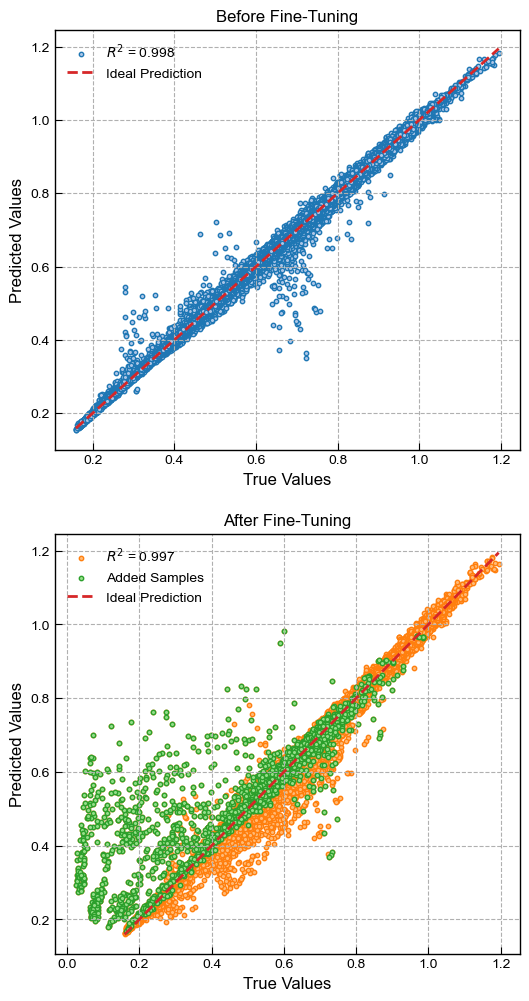

In [65]:
fig, axs = plt.subplots(2,1,figsize=(6, 12))

axs[0].scatter(y_truth_before, y_preds_before,
            label=rf'$R^2$ = {metrics_before["R2"]:.3f}', 
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[0],
            s=10
            )

axs[0].plot([y_truth_before.min(), y_truth_before.max()],
            [y_truth_before.min(), y_truth_before.max()], 
            color=plot_params.colors[3], linestyle='--', linewidth=2, label='Ideal Prediction')

axs[0].grid(True, linestyle='--', zorder=0)

axs[1].scatter(y_truth_after, y_preds_after, 
            label=rf'$R^2$ = {metrics_after["R2"]:.3f}', 
            facecolor=plot_params.morecolors[3],
            edgecolor=plot_params.morecolors[2],
            s=10
            )

axs[1].scatter(y_truth_after[ids_added], y_preds_after[ids_added],
            label='Added Samples', 
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            s=10
            )

axs[1].plot([y_truth_before.min(), y_truth_before.max()],
            [y_truth_before.min(), y_truth_before.max()], 
            color=plot_params.colors[3], linestyle='--', linewidth=2, label='Ideal Prediction')

axs[1].grid(True, linestyle='--', zorder=0)

axs[0].legend()
axs[1].legend()

axs[0].set_title('Before Fine-Tuning')
axs[1].set_title('After Fine-Tuning')

axs[0].set_xlabel('True Values')
axs[1].set_xlabel('True Values')

axs[0].set_ylabel('Predicted Values')
axs[1].set_ylabel('Predicted Values')

plt.show()

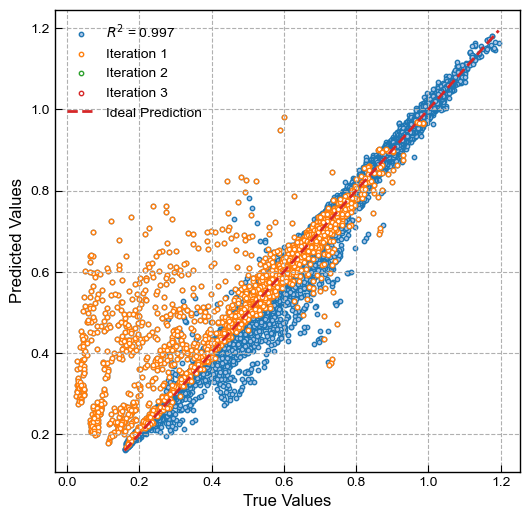

In [66]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_truth_after, y_preds_after, 
            label=rf'$R^2$ = {metrics_after["R2"]:.3f}', 
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[0],
            s=10,
            alpha=1.0
            )

for i in range(iterations):
    ax.scatter(y_truth_after[df_AL['iteration'] == i+1],
                y_preds_after[df_AL['iteration'] == i+1],
                label=f'Iteration {i+1}',
                facecolor='white',
                edgecolor=plot_params.morecolors[2*(i+1)],
                s=10,
                alpha=1.0
                )

ax.plot([y_truth_before.min(), y_truth_before.max()],
            [y_truth_before.min(), y_truth_before.max()], 
            color=plot_params.colors[3], linestyle='--', linewidth=2, label='Ideal Prediction')

ax.grid(True, linestyle='--', zorder=0)
ax.legend()
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')

plt.show()

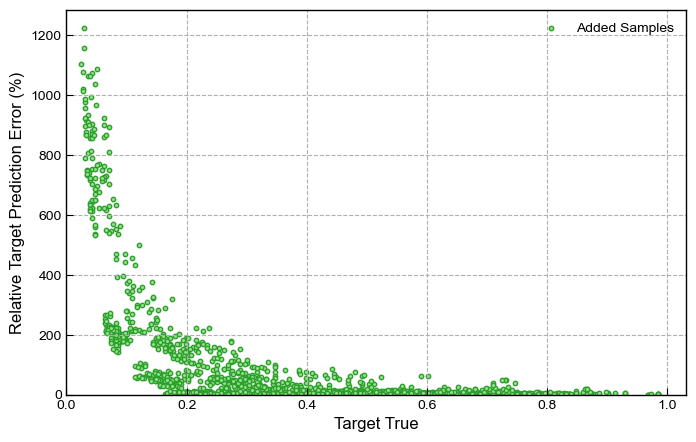

In [67]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.scatter(df_added['target'],error_added*100,
            label='Added Samples',
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            s=10
            )

plt.xlabel('Target True')
plt.ylabel('Relative Target Prediction Error (%)')
plt.legend()

plt.ylim(0, None)
plt.xlim(0, None)
plt.grid(True, linestyle='--', zorder=0)

plt.show()

In [46]:
worst_samples = np.argsort(error_added)[-10:]

df_added.iloc[worst_samples].sort_values(by='target', ascending=False)

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost,Unnamed: 0,base_sample_id,iteration,template
720381,HEA400,390,300,11.0,19.0,15897.778956,5732.778956,450700000,2311000.0,2562000,...,0.013098,0.018529,0.022691,0,1,31.483132,720381.0,161754.0,2.0,Corner.ideaCon
720379,HEA400,390,300,11.0,19.0,15897.778956,5732.778956,450700000,2311000.0,2562000,...,0.015414,0.016334,0.022458,0,1,31.483132,720379.0,161754.0,2.0,Corner.ideaCon
720351,HEA200,190,200,6.5,10.0,5383.123980,1808.123980,36920000,388600.0,429500,...,0.012158,0.018857,0.022436,0,1,6.851456,720351.0,153057.0,2.0,Corner.ideaCon
717762,HEA220,210,220,7.0,11.0,6434.123980,2067.123980,54100000,515200.0,568500,...,0.012079,0.018354,0.021973,1,1,9.087990,717762.0,246960.0,2.0,Corner.ideaCon
720384,HEA500,490,300,12.0,23.0,19753.778956,7471.778956,869700000,3550000.0,3949000,...,0.010104,0.015192,0.018245,1,1,43.829408,720384.0,401774.0,2.0,Corner.ideaCon
720375,HEA400,390,300,11.0,19.0,15897.778956,5732.778956,450700000,2311000.0,2562000,...,0.010478,0.014823,0.018153,0,1,31.483132,720375.0,162325.0,2.0,Corner.ideaCon
717729,HEA450,440,300,11.5,21.0,17802.778956,6578.278956,637200000,2896000.0,3216000,...,0.010273,0.014904,0.018101,0,1,38.110780,717729.0,163392.0,2.0,Corner.ideaCon
714695,HEA500,490,300,12.0,23.0,19753.778956,7471.778956,869700000,3550000.0,3949000,...,0.011890,0.013392,0.017909,1,1,43.829408,714695.0,401774.0,1.0,Corner.ideaCon
720382,HEA500,490,300,12.0,23.0,19753.778956,7471.778956,869700000,3550000.0,3949000,...,0.011890,0.013392,0.017909,1,1,43.829408,720382.0,401774.0,2.0,Corner.ideaCon
717727,HEA450,440,300,11.5,21.0,17802.778956,6578.278956,637200000,2896000.0,3216000,...,0.012089,0.013138,0.017854,0,1,38.110780,717727.0,163392.0,2.0,Corner.ideaCon


8 profiles found with the same fixed features


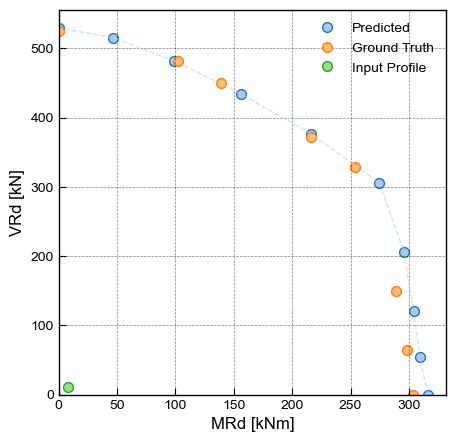

In [51]:
from Plot_Functions import plot_MV_interaction

plot_MV_interaction(df_added.iloc[worst_samples[0]:worst_samples[0]+1],model_AL,df_AL)

#### Loss Progression

Training and Validation Loss Spike

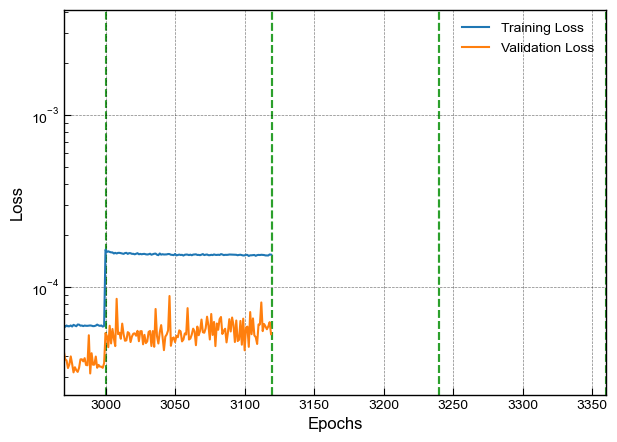

In [68]:
fig, ax = plt.subplots(figsize=(7,5))

plt.plot(model_AL.train_losses['total'], label='Training Loss', c=plot_params.colors[0],zorder=2)
plt.plot(model_AL.val_losses['total'], label='Validation Loss', c=plot_params.colors[1],zorder=2)

for i in range(iterations):
    iterations_start = model_AL.config['epochs'] + i * epochs_per_iter
    iterations_end = iterations_start + epochs_per_iter
    plt.axvline(x=iterations_start, color=plot_params.colors[2], linestyle='--',zorder=0)
    plt.axvline(x=iterations_end, color=plot_params.colors[2], linestyle='--',zorder=0)

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.yscale('log')

plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)
plt.xlim([0.99*model.config['epochs'],model.config['epochs']+iterations*epochs_per_iter])
plt.yscale('log')
plt.legend()

#### Features of Data Added

In [69]:
df_added = df_AL.loc[ids_added].copy()

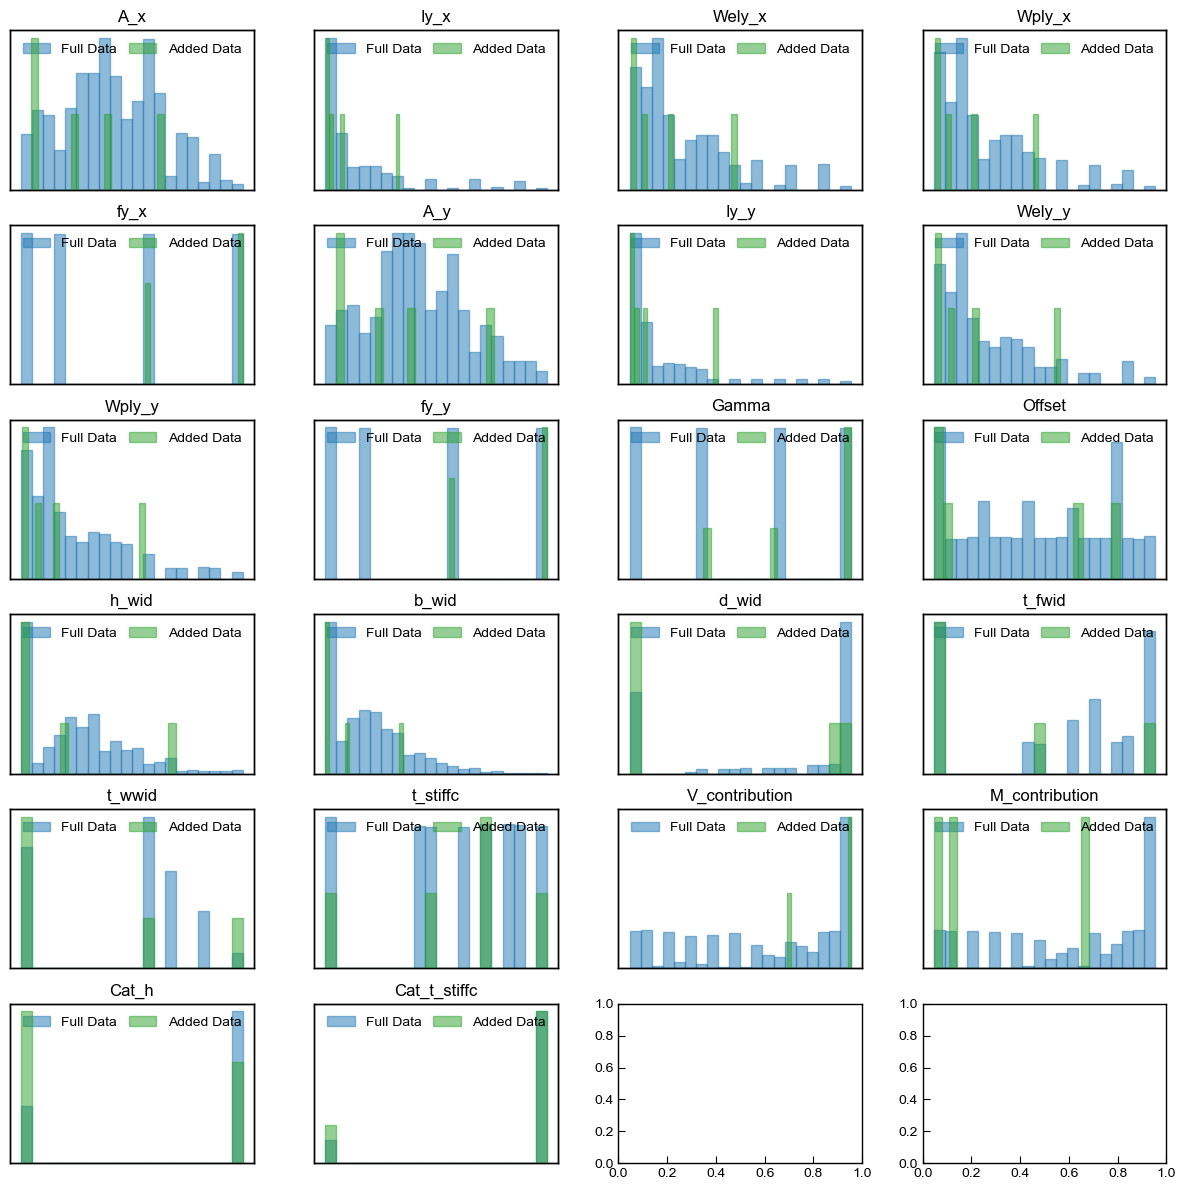

In [182]:
fig, axs = plt.subplots(int(len(model.features)/4)+1, 4, figsize=(12, 12), sharey=False)

for i, feature in enumerate(model.features):
    ax = axs[int(i/4), i%4]
    ax2 = ax.twinx()

    ax.hist(df_full[feature].values, bins=20, 
            edgecolor=plot_params.colors[0], 
            facecolor=plot_params.colors[0],
            alpha=0.5, label='Full Data')
    ax2.hist(df_added[feature].values, bins=20, 
             edgecolor=plot_params.colors[2],
             facecolor=plot_params.colors[2],
             alpha=0.5, label='Added Data')

    ax.set_title(feature)
    ax.set_xticks([])
    ax.set_yticks([])
    ax2.set_yticks([])
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Check added M-V location

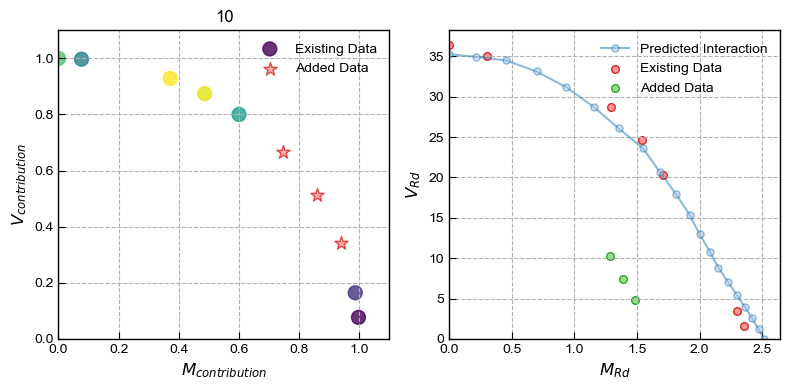

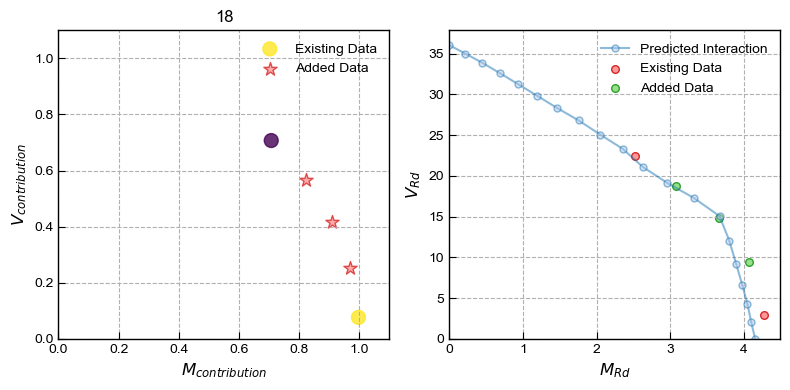

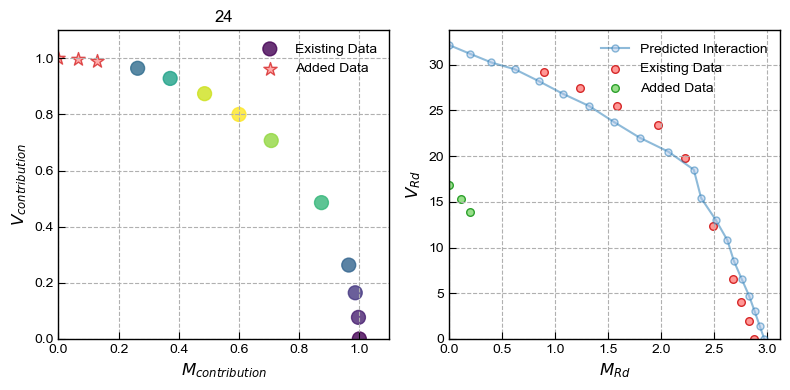

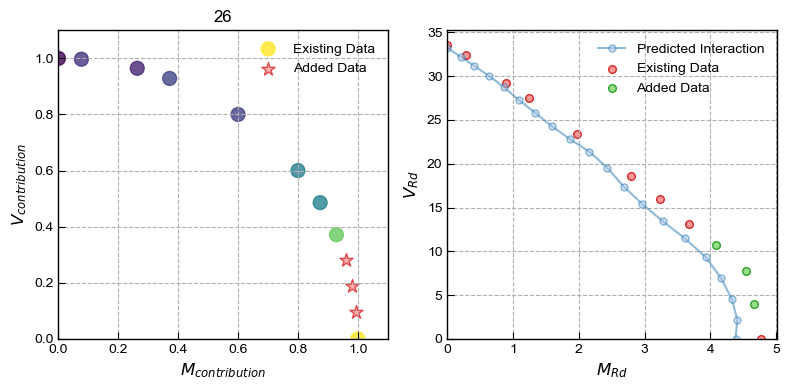

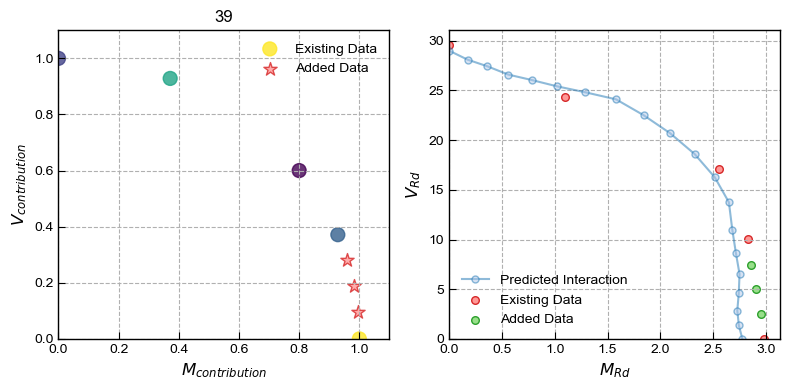

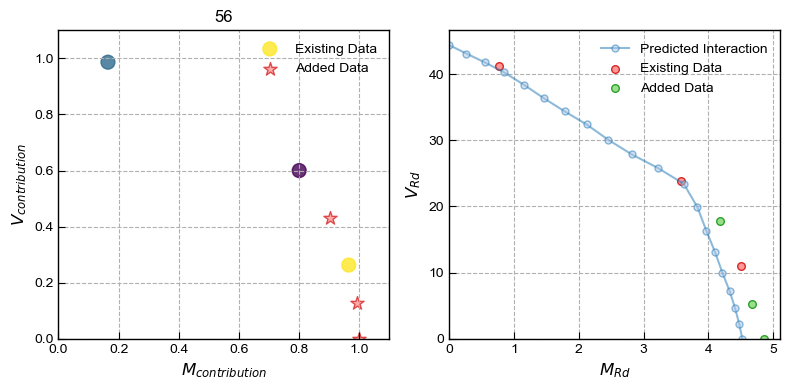

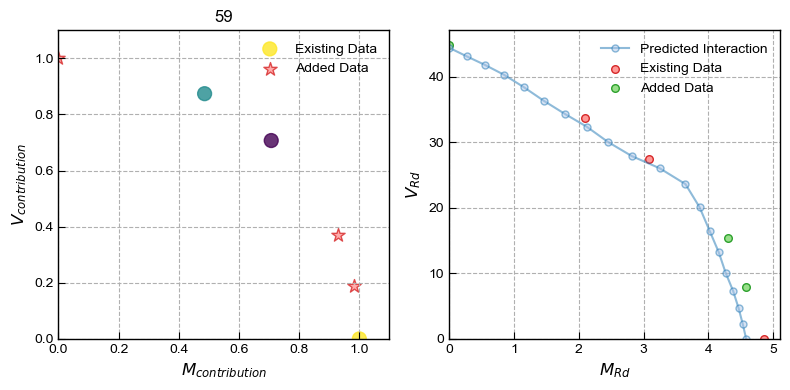

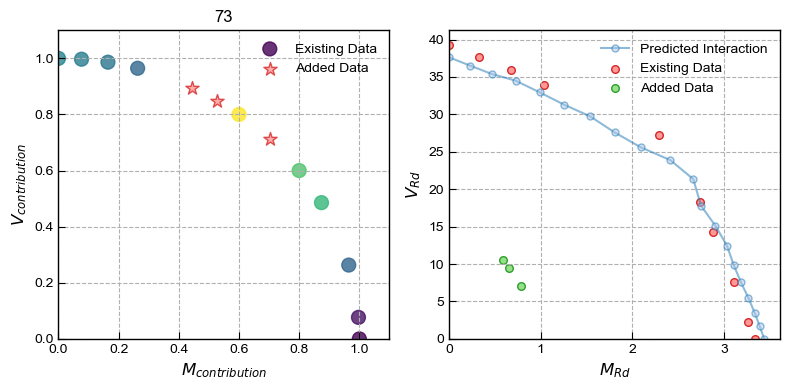

[64219, 64220, 64221, 64222, 64223, 64224, 717682, 717683, 717684]


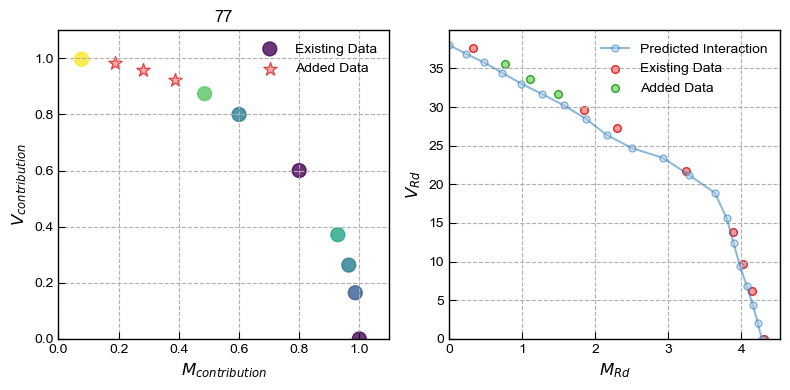

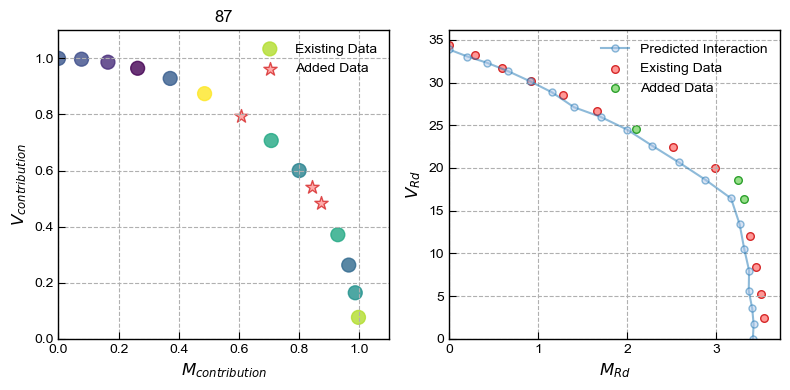

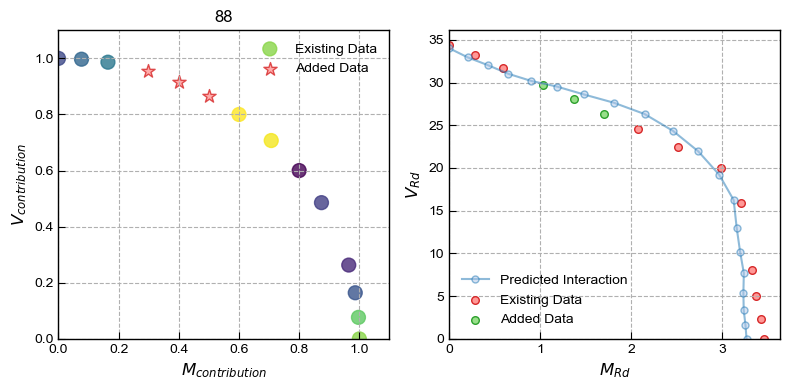

In [71]:
n_before = len(df_full)
counter = 0
for group_id,group in enumerate(identical_groups):
    if max(group) > n_before:
        if max(group) > len(df_AL):
            print(group)
            continue
        if counter > 10:
            break
        else:
            counter += 1

        M_contribution = df_AL.loc[group]['M_contribution'].values
        V_contribution = df_AL.loc[group]['V_contribution'].values
        
        mask_before = np.where(np.array(group) < n_before)[0]
        mask_added = np.where(np.array(group) >= n_before)[0]

        fig, axs = plt.subplots(1,2,figsize=(8, 4))
        ax = axs[0]
        ax.scatter(M_contribution[mask_before], V_contribution[mask_before],
                    label='Existing Data',
                    c=rel_error[np.array(group)[mask_before]],
                    alpha=0.8,
                    s=100)
        ax.scatter(M_contribution[mask_added], V_contribution[mask_added],
                    label='Added Data',
                    marker='*',
                    facecolor=plot_params.morecolors[7],
                    edgecolor=plot_params.morecolors[6],
                    alpha=0.8,
                    s=100)
        ax.set_xlabel(r'$M_{contribution}$')
        ax.set_ylabel(r'$V_{contribution}$')
        ax.grid(True, linestyle='--', zorder=0)
        ax.set_title(group_id)
        ax.set_xlim(0, 1.1)
        ax.set_ylim(0, 1.1)
        ax.legend()

        ax = axs[1]
        x_profile = df_AL.loc[group[0]].copy()
        df_group = df_AL.loc[group].copy()
        M_Rd_pred, V_Rd_pred, targets_predicted = model.get_MV_interaction_prediction(x_profile,n_predictions=20)
        ax.plot(M_Rd_pred, V_Rd_pred, 
                    label='Predicted Interaction',
                    marker='o',
                    c=plot_params.morecolors[0],
                    markerfacecolor=plot_params.morecolors[1],
                    markeredgecolor=plot_params.morecolors[0],
                    alpha=0.5,
                    markersize=5)

        ax.scatter(df_group['M_Rd'].values[mask_before], df_group['V_Rd'].values[mask_before],
                    label='Existing Data',
                    facecolor=plot_params.morecolors[7],
                    edgecolor=plot_params.morecolors[6],
                    alpha=1.0,
                    s=30)
        ax.scatter(df_group['M_Rd'].values[mask_added], df_group['V_Rd'].values[mask_added],
                    label='Added Data',
                    facecolor=plot_params.morecolors[5],
                    edgecolor=plot_params.morecolors[4],
                    alpha=1.0,
                    s=30)
        ax.set_xlabel(r'$M_{Rd}$')
        ax.set_ylabel(r'$V_{Rd}$')
        ax.set_xlim(0, None)
        ax.set_ylim(0, None)
        ax.grid(True, linestyle='--', zorder=0)
        ax.legend()

        plt.tight_layout()
        plt.show()

In [108]:
df_AL[df_AL['group_id']==6787][variable_features]

,t_stiffc,h_wid,b_wid,d_wid,t_fwid,t_wwid,t_stiffb
714391,25,88.666667,88.666667,140,10,10,0
714392,25,88.666667,88.666667,140,10,10,0
714393,25,88.666667,88.666667,140,10,10,0
714439,25,88.666667,88.666667,140,10,10,0
714440,25,88.666667,88.666667,140,10,10,0
714441,25,88.666667,88.666667,140,10,10,0


In [109]:
df_AL[df_AL['group_id']==6787]['template']

714391    Corner_Stiffner.ideaCon
714392    Corner_Stiffner.ideaCon
714393    Corner_Stiffner.ideaCon
714439    Corner_Stiffner.ideaCon
714440    Corner_Stiffner.ideaCon
714441    Corner_Stiffner.ideaCon
Name: template, dtype: object

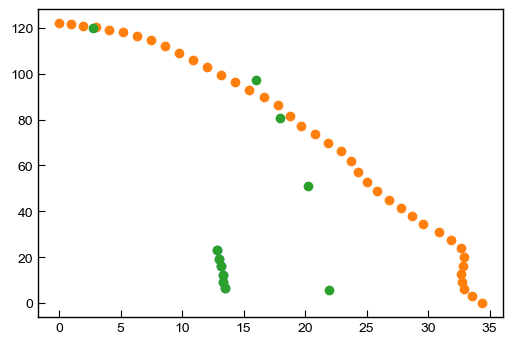

In [106]:
plt.scatter(df_AL[df_AL['group_id']==6787]['M_Rd'],df_AL[df_AL['group_id']==6787]['V_Rd'])
MRd, VRd, _ = model.get_MV_interaction_prediction(df_full.loc[df_AL[df_AL['group_id']==6787]['base_sample_id'].values[0]])
plt.scatter(MRd, VRd)
plt.scatter(df_AL.loc[np.array(identical_groups[6787])]['M_Rd'],
            df_AL.loc[np.array(identical_groups[6787])]['V_Rd'])

#### Check underestimation problem

In [79]:
n_before = len(df_full)
counter = 0
bad_ids = []
good_ids = []
for group_id,group in enumerate(identical_groups):
    if max(group) > n_before:
        if max(group) > len(df_AL):
            print(group)
            continue
        if counter > 1000:
            break
        else:
            counter += 1

        df_group = df_AL.loc[group].copy()
        
        mask_before = np.where(np.array(group) < n_before)[0]
        mask_added = np.where(np.array(group) >= n_before)[0]

        if len(mask_added) == 0 or len(mask_before) == 0:
            continue

        if np.abs(df_group['M_Rd'].values[mask_added].max() / (df_group['M_Rd'].values[mask_before].max()+1e-9)) < 0.5 and np.abs(df_group['V_Rd'].values[mask_added].max() / (df_group['V_Rd'].values[mask_before].max()+1e-9)) < 0.5:
            bad_ids.append(group[0])
        else:
            good_ids.append(group[0])

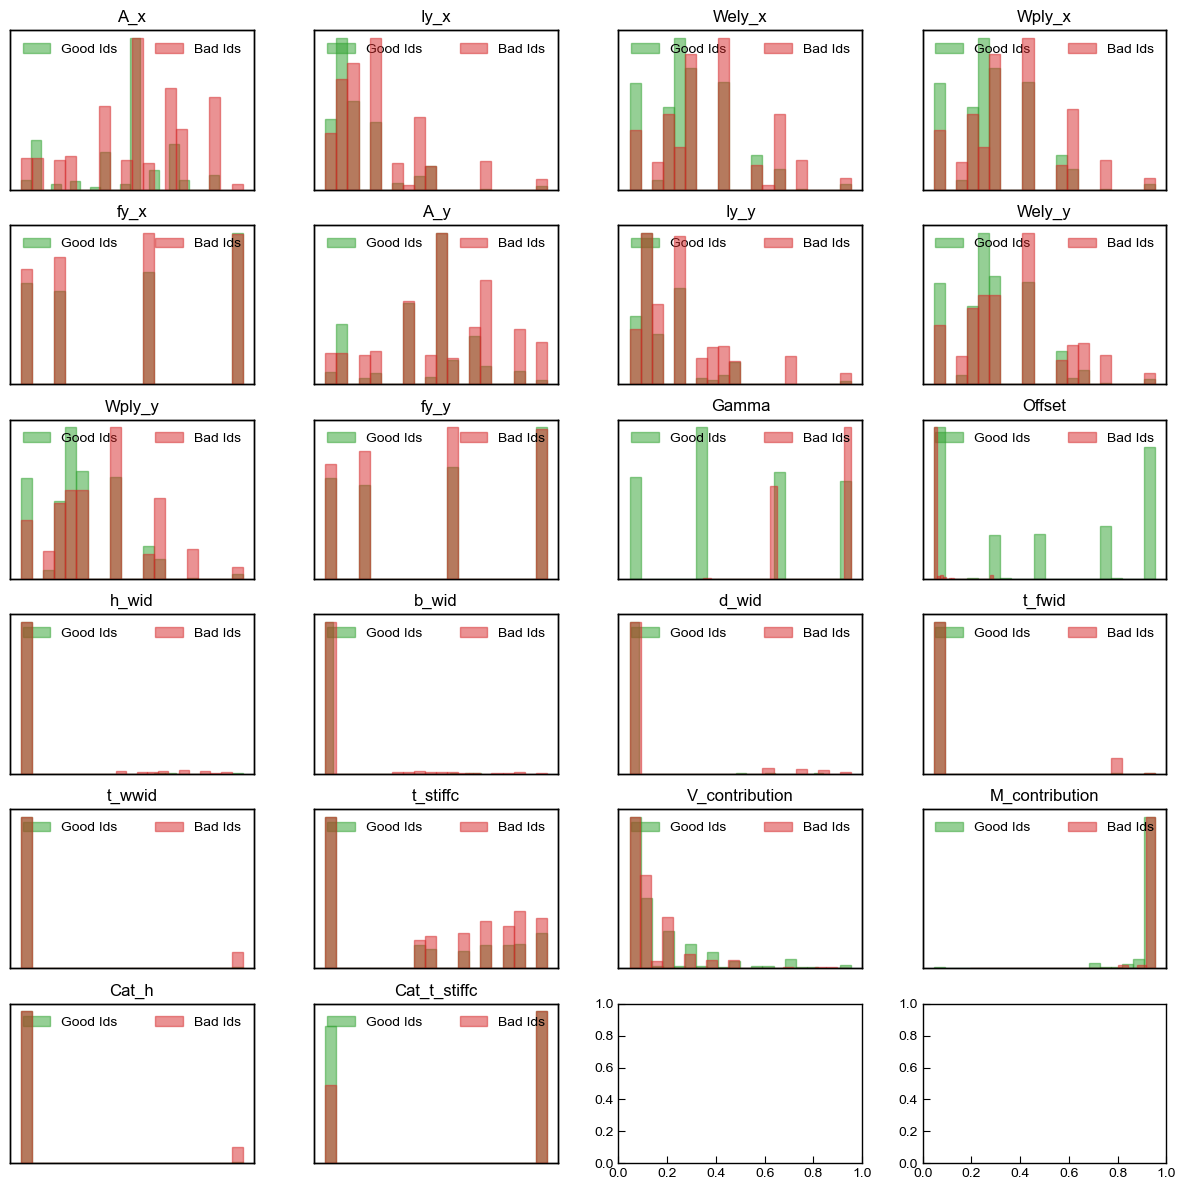

In [80]:
fig, axs = plt.subplots(int(len(model.features)/4)+1, 4, figsize=(12, 12), sharey=False)

for i, feature in enumerate(model.features):
    ax = axs[int(i/4), i%4]
    ax2 = ax.twinx()

    ax.hist(df_AL[feature].values[good_ids], bins=20, 
            edgecolor=plot_params.colors[2], 
            facecolor=plot_params.colors[2],
            alpha=0.5, label='Good Ids')
    ax2.hist(df_AL[feature].values[bad_ids], bins=20, 
             edgecolor=plot_params.colors[3],
             facecolor=plot_params.colors[3],
             alpha=0.5, label='Bad Ids')

    ax.set_title(feature)
    ax.set_xticks([])
    ax.set_yticks([])
    ax2.set_yticks([])
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Uncertainty

In [198]:
mcd_mean, mcd_std, _ = model.mc_dropout_uncertainty(df_added, num_samples=200)
uncertainty_added = mcd_std.flatten() / mcd_mean.flatten()

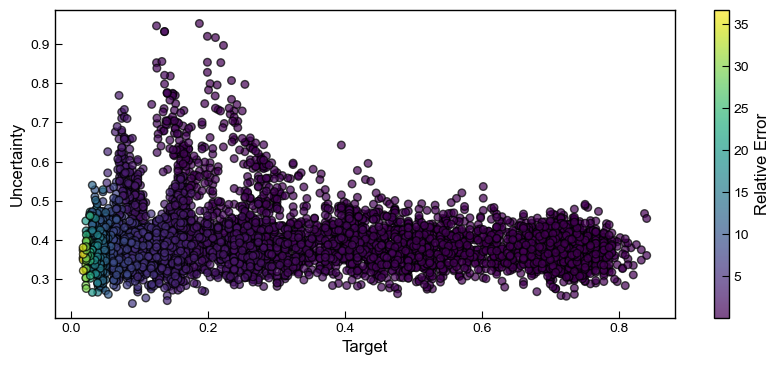

In [216]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.scatter(df_added['target'], uncertainty_added, label='Added Data',
            c=error_added, cmap='viridis', edgecolor='black', s=30, alpha=0.7)

plt.colorbar(label='Relative Error')
plt.xlabel('Target')
plt.ylabel('Uncertainty')
plt.show()

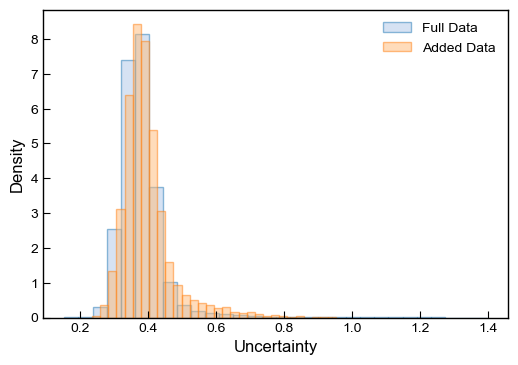

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.hist(uncertainty_full, bins=30,
         edgecolor=plot_params.morecolors[0], 
         facecolor=plot_params.morecolors[1], 
         alpha=0.5, label='Full Data',
         density=True)

plt.hist(uncertainty_added, bins=30, 
         edgecolor=plot_params.morecolors[2], 
         facecolor=plot_params.morecolors[3], 
         alpha=0.5, label='Added Data',
         density=True)

plt.legend()
plt.xlabel('Uncertainty')
plt.ylabel('Density')

plt.show()

## Global Exploration

In [ ]:
import random

In [ ]:
directory = Directory()

Root Directory set to:  C:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [ ]:
hypercubemap = np.load(r"Saved Variables\hypercubemap.npy")

In [ ]:
def find_bins(datapoint, bounds, m):
    bin_widths = (bounds[:, 1] - bounds[:, 0]) / m
    if np.any(datapoint < bounds[:, 0]) or np.any(datapoint > bounds[:, 1]):
        return None
    
    bin_indices = ((datapoint - bounds[:, 0]) / bin_widths).astype(int)
    bin_indices = np.clip(bin_indices, 0, m - 1)
    
    return tuple(bin_indices)

In [ ]:
def check_feasibility(datapoint, hypercubemap, bounds, m):
    bin_indices = find_bins(datapoint, bounds, m)

    if bin_indices is None:
        return 'Datapoint is out of bounds'
    
    closest_index = np.argmin(np.sum((hypercubemap - bin_indices) ** 2, axis=1))
    closest_bin = hypercubemap[closest_index]
    error = np.abs(closest_bin - bin_indices)

    feasibilty_degree = np.max(error)

    return feasibilty_degree, np.sum(error)/len(error)

In [ ]:
features_feasibility = ["A_x", "Iy_x", "Wely_x", "Wply_x", "fy_x",
                        "A_y", "Iy_y", "Wely_y", "Wply_y", "fy_y",
                        "Gamma", "Offset",
                        "h_wid", "b_wid", "d_wid", "t_fwid", "t_wwid", 
                        "t_stiffc", "t_stiffb",
                        "Cat_h", "Cat_t_stiffc"] 

In [ ]:
features_feasibility = ['h_x', 'b_x', 'tw_x', 'tf_x', 'A_x', 'Av_x', 'Iy_x',
       'Wely_x', 'Wply_x', 'fy_x', 'tau_x', 'Vpl_x', 'Mpl_x',
       'h_y', 'b_y', 'tw_y', 'tf_y', 'A_y', 'Av_y', 'Iy_y',
       'Wely_y', 'Wply_y', 'fy_y', 'tau_y', 'Vpl_y', 'Mpl_y',
       'Gamma', 't_stiffc', 'h_wid', 'b_wid', 'd_wid', 't_fwid', 't_wwid',
       't_stiffb', 'Offset', 
       'Cat_h', 'Cat_t_stiffc', 'cost']

In [ ]:
bounds = np.array([df_full[features_feasibility].min(), df_full[features_feasibility].max()]).T
m = np.max(hypercubemap)
lower_bounds = bounds[:, 0]
bin_widths = (bounds[:, 1] - bounds[:, 0]) / m

In [ ]:
def sample_from_bins(bounds, m, map):
    lower_bounds = bounds[:, 0]
    upper_bounds = bounds[:, 1]
    bin_widths = (upper_bounds - lower_bounds) / m

    bin_starts = lower_bounds + bin_widths * map
    bin_ends = bin_starts + bin_widths

    return np.random.uniform(bin_starts, bin_ends)

Define from what ratio of the Hypercubemap should be sampled from:

In [ ]:
ratio = 1.0 # of the hypercube map to sample

n_samples = int(ratio * len(hypercubemap))
print(f"Sampling {n_samples} samples from the hypercube map.")

Sampling 117228 samples from the hypercube map.


Select Hypercubes to sample from:

In [ ]:
sampling_hypercube_ids = random.choices(np.arange(len(hypercubemap)),k=n_samples)
hypercube_samples = np.zeros((n_samples, len(features_feasibility)))

for hypercube_id in sampling_hypercube_ids:
    sampled_point = sample_from_bins(bounds, m, hypercubemap[hypercube_id])
    
    hypercube_samples[hypercube_id] = sampled_point

Define how many load combinations should be considered per sample:

In [ ]:
loads_per_curve = 3

Convert the samples to a DataFrame:

In [ ]:
template_profile = df_full.iloc[0:1].copy()

for col in template_profile.columns:
    template_profile[col] = None

df_template = pd.DataFrame([template_profile.values[0]] * n_samples * loads_per_curve, columns=template_profile.columns)

In [ ]:
df_hypercube_samples = df_template.copy()

df_hypercube_samples[features_feasibility] = np.repeat(hypercube_samples, loads_per_curve, axis=0)

M_contributions = np.linspace(1, 0, loads_per_curve)
V_contributions = np.linspace(0, 1, loads_per_curve)

df_hypercube_samples['M_contribution'] = np.repeat(M_contributions, n_samples)
df_hypercube_samples['V_contribution'] = np.repeat(V_contributions, n_samples)

Get Metrics of samples:

In [ ]:
mcd_mean_hypercube, mcd_std_hypercube, _ = model.mc_dropout_uncertainty(df_hypercube_samples, num_samples=100)
uncertainty_hypercube = mcd_std_hypercube / mcd_mean_hypercube

In [ ]:
y_preds_hypercube, _ = model.predict(df_hypercube_samples)

In [ ]:
y_preds_hypercube = y_preds_hypercube.numpy().flatten()

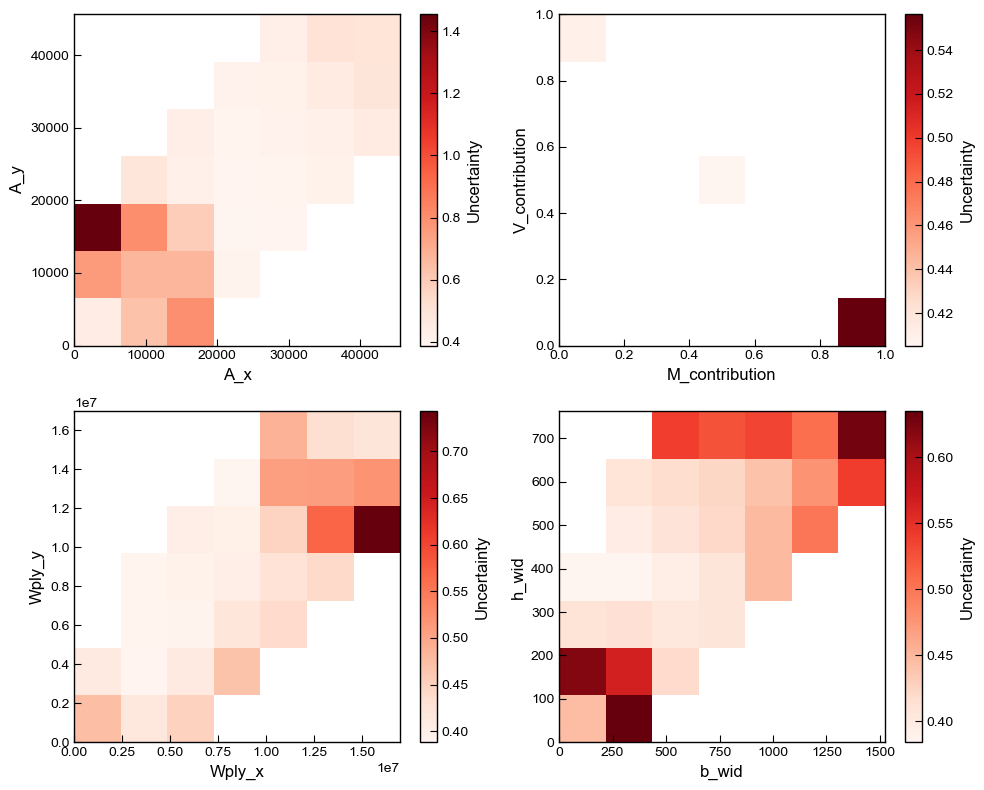

In [ ]:
from scipy.stats import binned_statistic_2d

grid_x, grid_y = m, m

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i,(x_feature,y_feature) in enumerate(zip(['A_x','M_contribution','Wply_x','b_wid'],['A_y','V_contribution','Wply_y','h_wid'])):
    
    x = df_hypercube_samples[x_feature].values
    y = df_hypercube_samples[y_feature].values
    c = uncertainty_hypercube.flatten()

    stat, x_edges, y_edges, _ = binned_statistic_2d(
        x, y, c, statistic='median', bins=[grid_x, grid_y]
    )

    X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, 
                    (y_edges[:-1] + y_edges[1:]) / 2)

    pcm = axs[int(i/2),i%2].pcolormesh(X, Y, stat.T, cmap='Reds', shading='auto')

    fig.colorbar(pcm, ax=axs[int(i/2),i%2], label="Uncertainty")

    axs[int(i/2),i%2].set_xlabel(x_feature)
    axs[int(i/2),i%2].set_ylabel(y_feature)


plt.tight_layout()
plt.show()

Identify and select the n most uncertain samples. Check if selected samples are from same hypercube.

In [ ]:
n_most_uncertain = 10
most_uncertain_hypercubes = np.argsort(uncertainty_hypercube.flatten())[-n_most_uncertain:]

In [ ]:
index_mapping = np.repeat(np.arange(n_samples), loads_per_curve,axis=0)

In [ ]:
print(f"{len(np.unique(index_mapping[most_uncertain_hypercubes]))} of {len(most_uncertain_hypercubes)} are unique hypercubes.")

10 of 10 are unique hypercubes.


In [ ]:
df_add_to_data = df_hypercube_samples.loc[most_uncertain_hypercubes].copy()

In [ ]:
model_AL = copy.deepcopy(model)
df_AL = df_full.copy()

In [ ]:
idea_templates = []

for i,sample in df_add_to_data.iterrows():
    idea_templates.append(get_ideatemplate(sample))

df_add_to_data['ideatemplate'] = idea_templates

In [ ]:
os.chdir(r"AL_API")
c5 = pd.read_excel('C5_Geometrie.xlsx')
geometry_profile = c5.iloc[:, list(range(5)) + [15] + [16] + [20] + [21] + [23]]

In [ ]:
geometry_profile

,Profile,h,b,tw,tf,A,Av,Iy,Wely,Wply
0,HEA100,96,100,5.0,8.0,2123.610658,755.610658,3492000,72760.0,83010
1,HEA120,114,120,5.0,8.0,2533.610658,845.610658,6062000,106300.0,119500
2,HEA140,133,140,5.5,8.5,3141.610658,1012.360658,10330000,155400.0,173500
3,HEA160,152,160,6.0,9.0,3877.141653,1321.141653,16730000,220100.0,245100
4,HEA180,171,180,6.0,9.5,4525.141653,1447.141653,25100000,293600.0,324900
...,...,...,...,...,...,...,...,...,...,...
61,IPE400,400,180,8.6,13.5,8446.357640,4269.457640,231300000,1160000.0,1307000
62,IPE450,450,190,9.4,14.6,9882.077640,5084.517640,337400000,1500000.0,1702000
63,IPE500,500,200,10.2,16.0,11552.157640,5987.357640,482000000,1930000.0,2194000
64,IPE550,550,210,11.1,17.2,13441.602632,7234.122632,671200000,2440000.0,2787000


In [ ]:
Av = c5['Av'].values
tw = c5['tw'].values
h = c5['h'].values
tf = c5['tf'].values
b = c5['b'].values
r = c5['r'].values
A = c5['A'].values

In [ ]:
from scipy.stats import linregress

x = b
y = r

slope, intercept, r_value, p_value, std_err = linregress(x, y)

print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")

Slope: 0.08400521697889492, Intercept: 2.3215160856849337, R^2: 0.9502222132724109


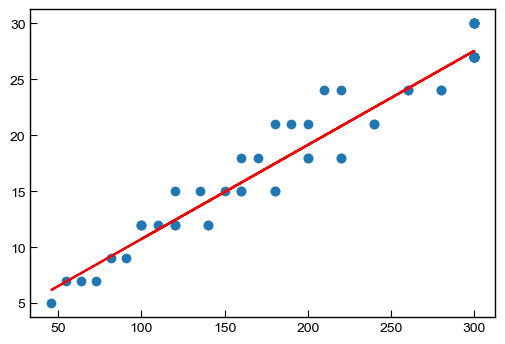

In [ ]:
plt.scatter(b,r)
plt.plot(x, slope * x + intercept, color='red', label='Regression Line')

In [ ]:
r_func = lambda b: slope * b + intercept

$$A_v = A-2bt_f+(t_w+2r)t_f$$

In [ ]:
Av_calc = df_full['A_x'] - 2 * df_full['b_x'] * df_full['tf_x'] + (df_full['tw_x'] + 2 * r_func(df_full['b_x'].values)) * df_full['tf_x']

In [ ]:
Av_calculation_error = df_full['Av_x'] / Av_calc

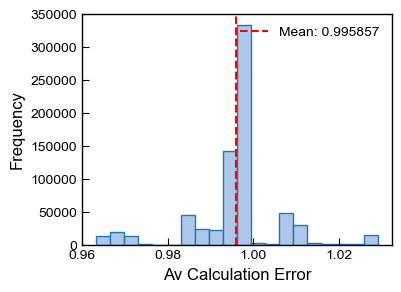

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))

plt.hist(Av_calculation_error, bins=20, 
         color=plot_params.morecolors[1], 
         edgecolor=plot_params.morecolors[0],)

plt.axvline(np.mean(Av_calculation_error), color='red', linestyle='--', label=f'Mean: {Av_calculation_error.mean():.6f}')

plt.xlabel('Av Calculation Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
Aw = h * tw + c5['r'].values*4

In [ ]:
Aw/Av

array([0.69877257, 0.73083279, 0.76998251, 0.73572731, 0.75044485,
       0.72284866, 0.74596396, 0.71855356, 0.68540009, 0.71067594,
       0.69022333, 0.7045474 , 0.72146365, 0.73696138, 0.7671672 ,
       0.78561582, 0.80141557, 0.81918073, 0.83447961, 0.84777473,
       0.86456004, 0.86223249, 0.87922495, 0.89157676, 0.71712302,
       0.75539818, 0.78616673, 0.76173513, 0.78551815, 0.75388906,
       0.77432092, 0.74761683, 0.71712758, 0.73878632, 0.71856606,
       0.7316938 , 0.74668658, 0.76045515, 0.78710689, 0.8044411 ,
       0.8192141 , 0.8352338 , 0.84903778, 0.86104477, 0.87587116,
       0.87294849, 0.88847369, 0.8998254 , 0.90578651, 0.86137055,
       0.88178113, 0.89763323, 0.8656655 , 0.87989754, 0.83427936,
       0.84753732, 0.80861619, 0.83204534, 0.85274674, 0.82671346,
       0.84013429, 0.82539758, 0.84845807, 0.86582434, 0.85718757,
       0.87080623])

Can I get Vpl from the geometry or do I need it in the feasibilty map?

In [ ]:
df_add_to_data

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,M_contribution,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost,ideatemplate,Mmax,Vmax
71636,None,None,None,None,None,15990.145813,None,7.808194e+08,3.448620e+06,1.975239e+06,...,1.0,None,None,None,1.100539,1.139955,None,Corner_Stiff_Wid.ideaCon,920.301307,None
24659,None,None,None,None,None,7732.404439,None,6.423811e+08,1.459100e+06,1.400254e+06,...,1.0,None,None,None,1.003909,1.035539,None,Corner_Stiff_Wid.ideaCon,382.406081,None
29539,None,None,None,None,None,6945.690350,None,2.984043e+08,1.593968e+06,9.852117e+05,...,1.0,None,None,None,0.069773,1.126324,None,Corner_Stiff_Wid.ideaCon,496.714350,None
79362,None,None,None,None,None,12053.656448,None,2.491413e+08,3.177064e+06,2.652003e+06,...,1.0,None,None,None,1.044866,1.027465,None,Corner_Stiff_Wid.ideaCon,723.921032,None
61530,None,None,None,None,None,15742.823457,None,1.063548e+08,2.962970e+06,9.633213e+05,...,1.0,None,None,None,1.127181,1.036763,None,Corner_Stiff_Wid.ideaCon,278.854051,None
24657,None,None,None,None,None,7732.404439,None,6.423811e+08,1.459100e+06,1.400254e+06,...,1.0,None,None,None,1.003909,1.035539,None,Corner_Stiff_Wid.ideaCon,382.406081,None
62295,None,None,None,None,None,13258.549577,None,1.413138e+08,3.252327e+06,1.759640e+06,...,1.0,None,None,None,1.032245,1.051523,None,Corner_Stiff_Wid.ideaCon,507.736762,None
65947,None,None,None,None,None,13423.135697,None,7.243316e+08,3.651316e+06,5.945609e+05,...,1.0,None,None,None,1.095974,1.007664,None,Corner_Stiff_Wid.ideaCon,382.522992,None
55563,None,None,None,None,None,17479.815963,None,8.395947e+07,3.408585e+06,4.228138e+05,...,1.0,None,None,None,1.081996,1.047115,None,Corner_Stiff_Wid.ideaCon,263.571590,None
66325,None,None,None,None,None,15316.285510,None,6.186547e+08,3.285536e+06,1.769241e+06,...,1.0,None,None,None,0.075349,0.025380,None,Corner_Stiff_Wid.ideaCon,681.639740,None


In [ ]:
df_full['fy_x'] / np.sqrt(3) / df_full['tau_x']

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
714380    1.0
714381    1.0
714382    1.0
714383    1.0
714384    1.0
Length: 714385, dtype: float64

In [ ]:
df_add_to_data['tau _x'] = df_add_to_data['fy_x'] / np.sqrt(3)
df_add_to_data['tau _y'] = df_add_to_data['fy_y'] / np.sqrt(3)

In [ ]:
features_feasibility

['A_x',
 'Iy_x',
 'Wely_x',
 'Wply_x',
 'fy_x',
 'A_y',
 'Iy_y',
 'Wely_y',
 'Wply_y',
 'fy_y',
 'Gamma',
 'Offset',
 'h_wid',
 'b_wid',
 'd_wid',
 't_fwid',
 't_wwid',
 't_stiffc',
 't_stiffb',
 'Cat_h',
 'Cat_t_stiffc']

In [ ]:
df_add_to_data['Av_x'] = df_add_to_data['A_x'] - 2 * df_add_to_data['b_x'] * df_add_to_data['tf_x'] + (df_add_to_data['tw_x'] + 2 * r_func(df_add_to_data['b_x'].values)) * df_add_to_data['tf_x'] 

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [ ]:
df_add_to_data['Mpl_x'] = df_add_to_data['Wply_x'] * df_add_to_data['fy_x'] / 1000000
df_add_to_data['Vpl_x'] = df_add_to_data['Av_x'] * df_add_to_data['tau_x'] / 1000
df_add_to_data['Mpl_y'] = df_add_to_data['Wply_y'] * df_add_to_data['fy_y'] / 1000000
df_add_to_data['Vpl_y'] = df_add_to_data['Av_y'] * df_add_to_data['tau_y'] / 1000

In [ ]:
df_add_to_data['Mmax'] = df_add_to_data[['Mpl_x', 'Mpl_y']].max(axis=1)
df_add_to_data['Vmax'] = df_add_to_data[['Vpl_x', 'Vpl_y']].max(axis=1)
df_add_to_data['M'] = df_add_to_data['M_contribution'] * df_add_to_data['Mmax']
df_add_to_data['V'] = df_add_to_data['V_contribution'] * df_add_to_data['Vmax']

In [ ]:
for idea_template in df_add_to_data['ideatemplate'].unique():
    print(idea_templates)
    df_to_add = df_add_to_data[df_add_to_data['ideatemplate'] == idea_templates].copy()

    IdeaName = os.path.join(PATH,idea_template)

    conn = IdeaConnectionClient()
    conn.open(IdeaName)

    for j in list(df_to_add.index):

        params = {
            'Prof_c': df_to_add.at[j, 'Profile_x'], 'Prof_b': df_to_add.at[j, 'Profile_y'],
            'steel_grade': df_to_add.at[j, 'Steel grade_x'], 'gamma': df_to_add.at[j, 'Gamma'],
            'h_wid': df_to_add.at[j, 'h_wid']/1000, 'b_wid': df_to_add.at[j, 'b_wid']/1000,
            'd_wid': df_to_add.at[j, 'd_wid']/1000, 't_fwid': df_to_add.at[j, 't_fwid']/1000,
            't_wwid': df_to_add.at[j, 't_wwid']/1000,
            't_stiffc': df_to_add.at[j, 't_stiffc']/1000, 't_stiffb': df_to_add.at[j, 't_stiffb']/1000,
            'offset': df_to_add.at[j, 'Offset']/1000
        }

        print('      Set Load in Idea')

        conn.update_params_by_name(params)
        if not conn.params_valid():
            raise Exception("Parameters validation failed.")
        
        loads = conn.get_loads()

        loads[0]['forcesOnSegments'][1]['my'] = int(df_to_add.at[j,'M']*1000)
        loads[0]['forcesOnSegments'][1]['qz'] = int(df_to_add.at[j,'V']*1000)#!!!!

        conn.set_loads(loads) 
        print('      M=',loads[0]['forcesOnSegments'][1]['my'] )
        print('      V=',loads[0]['forcesOnSegments'][1]['qz'] )           

        print('      Calculate...') 
        calculated = conn.calculate()
        if calculated == False:
            overloaded(calculated,df_add_to_data,j)

        results = conn.get_results()
        loads = conn.get_loads()
        applied_percentage = results['analysis']['1']['appliedLoadPercentage']   
        if applied_percentage == 1:
            underloaded(applied_percentage,df_add_to_data,j)

        applied_M = applied_percentage * loads[0]['forcesOnSegments'][1]['my']
        applied_V = applied_percentage * loads[0]['forcesOnSegments'][1]['qz']

        df_add_to_data.at[j, 'proz'] = applied_percentage
        df_add_to_data.at[j, 'M_Rd'] = applied_M/1000 # [kNm]
        df_add_to_data.at[j, 'V_Rd'] = applied_V/1000 # [kN]

        cost = results['costEstimationResults']['totalEstimatedCost']
        df_add_to_data.at[j, 'cost'] = cost

['Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon']
C:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks\AL_API\Corner_Stiff_Wid.ideaCon
      Set Load in Idea
      M= 236191
      V= 0
      Calculate...
j = 0
Applied percentage = 1.0
M= 259810
V= 0
j = 1
Applied percentage = 1.0
M= 285791
V= 0
j = 2
Applied percentage = 1.0
M= 314370
V= 0
j = 3
Applied percentage = 1.0
M= 345807
V= 0
j = 4
Applied percentage = 1.0
M= 380388
V= 0
j = 5
Applied percentage = 1.0
M= 418427
V= 0
j = 6
Applied percentage = 1.0
M= 460270
V= 0
j = 7
Applied percentage = 1.0
M= 506297
V= 0
j = 8
Applied percentage = 1.0
M= 556926
V= 0
j = 9
Applied percentage = 1.0
M= 612619
V= 0
j = 10
Applied percentage = 1.0
M= 673881
V= 0
j = 11
Applied percentage = 1.0
M= 741269


In [ ]:
df_add_to_data

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,M_contribution,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost,ideatemplate,Mmax,Vmax
89490,None,267.735476,311.377334,10.386557,21.128687,12128.491632,3852.832142,5.195952e+08,3.516126e+06,3.412910e+05,...,1.0,None,None,None,1.042126,1.036205,960.596115,Corner_Stiff_Wid.ideaCon,236.191411,558.664669
90455,None,324.885698,321.777862,12.111239,19.613625,14792.308292,4930.179370,6.795741e+07,3.453771e+06,9.662765e+05,...,1.0,None,None,None,1.033816,1.074467,683.304415,Corner_Stiff_Wid.ideaCon,256.758236,675.301656
120629,None,385.270419,302.417818,12.334466,16.528509,12691.897673,5058.725140,3.477871e+08,3.085818e+06,1.634738e+06,...,0.5,None,None,None,1.034351,1.119202,797.132707,Corner_Stiff_Wid.ideaCon,475.153338,933.914248
29657,None,118.122394,201.012075,6.649391,9.965282,3563.524531,817.002092,1.280801e+08,1.754655e+06,1.444259e+06,...,1.0,None,None,None,1.048311,1.112972,897.145108,Corner_Stiff_Wid.ideaCon,546.241237,676.527527
116213,None,367.072801,309.786550,12.213097,14.225329,14180.328462,5787.157548,3.173656e+08,3.208289e+06,1.389522e+06,...,1.0,None,None,None,1.093799,1.007965,1171.295175,Corner_Stiff_Wid.ideaCon,357.760912,872.079726
89362,None,258.499231,326.201980,11.860005,19.740813,12449.115734,5719.475387,9.003381e+07,3.011360e+06,1.313741e+05,...,1.0,None,None,None,1.099776,1.017943,1492.264876,Corner_Stiff_Wid.ideaCon,478.064131,888.015088
59182,None,236.219110,271.879316,7.812025,9.760639,6703.967824,3269.346164,4.477399e+08,1.750448e+06,6.245225e+05,...,1.0,None,None,None,0.115846,0.129617,198.430192,Corner_Stiff_Wid.ideaCon,599.282657,1170.204199
93761,None,218.985329,314.764041,11.255313,20.012484,15464.802151,6239.718493,7.146613e+07,2.903910e+06,6.904788e+05,...,1.0,None,None,None,1.038094,1.003370,484.150808,Corner_Stiff_Wid.ideaCon,192.772441,1044.472199
92458,None,301.057186,302.699345,11.193675,18.704416,14112.001168,5039.290303,3.550768e+08,3.204865e+06,1.208964e+06,...,1.0,None,None,None,1.037773,1.095470,625.973324,Corner_Stiff_Wid.ideaCon,340.009207,953.129506
55436,None,287.059724,299.400827,6.442034,13.176127,9420.992599,983.537438,3.617923e+07,8.954014e+05,1.756225e+06,...,1.0,None,None,None,1.097152,1.120290,995.413934,Corner_Stiff_Wid.ideaCon,678.478911,835.342276


In [ ]:
current_id = len(df_AL)
# Get the most uncertain samples
print('Get Uncertainties')

for group_index, group in enumerate(most_uncertain_groups):
    print(f"   Process Group {group_index}/{len(most_uncertain_groups)} {group}")
    
    identical_groups[group].append(np.arange(current_id, current_id + add_per_group))
    base_id = identical_groups[group][0]

    base_profile = df_AL.iloc[base_id:base_id+1].copy()
    base_profile['M_Rd'] = None
    base_profile['V_Rd'] = None
    base_profile['M'] = None
    base_profile['V'] = None
    base_profile['proz'] = None

    new_profiles = pd.concat([base_profile]*add_per_group, ignore_index=True)
    new_profiles.index = current_id + np.arange(add_per_group)

    group_profiles = df_AL.iloc[most_uncertain_group_ids].copy()
    group_uncertainty = uncertainty[most_uncertain_group_ids]

    V_contributions = group_profiles['V_contribution'].values
    group_uncertainty_combined = group_uncertainty.copy()

    for j in list(new_profiles.index):
        print('      Add Load')
        ratio = find_optimal_location(V_contributions, group_uncertainty_combined)
        M_contribution, V_contribution = get_MV_contribution(ratio)

        new_profiles.at[j, 'M_contribution'] = round(M_contribution, 6)
        new_profiles.at[j, 'V_contribution'] = round(V_contribution, 6)

        V_contributions = np.append(V_contributions, V_contribution)
        group_uncertainty_combined = np.append(group_uncertainty_combined, max(group_uncertainty))

        current_id += 1

    print('   Find Template & Open Idea')
    # Calculation of the new Profiles
    ideatemplate = get_ideatemplate(base_profile)

    conn = IdeaConnectionClient()
    conn.open(IdeaName)

    # Define the loads:
    new_profiles['Mmax'] = new_profiles[['Mpl_x', 'Mpl_y']].max(axis=1)
    new_profiles['Vmax'] = new_profiles[['Vpl_x', 'Vpl_y']].max(axis=1)
    # new_data['Omega'] = (new_data['Vmax']**2+new_data['Mmax']**2)**0.5
    new_profiles['M'] = new_profiles['M_contribution'] * new_profiles['Mmax']
    new_profiles['V'] = new_profiles['V_contribution'] * new_profiles['Vmax']

    new_profiles = new_profiles.drop(columns=['Mmax','Vmax'])

    for j in list(new_profiles.index):

        params = {
            'Prof_c': new_profiles.at[j, 'Profile_x'], 'Prof_b': new_profiles.at[j, 'Profile_y'],
            'steel_grade': new_profiles.at[j, 'Steel grade_x'], 'gamma': new_profiles.at[j, 'Gamma'],
            'h_wid': new_profiles.at[j, 'h_wid']/1000, 'b_wid': new_profiles.at[j, 'b_wid']/1000,
            'd_wid': new_profiles.at[j, 'd_wid']/1000, 't_fwid': new_profiles.at[j, 't_fwid']/1000,
            't_wwid': new_profiles.at[j, 't_wwid']/1000,
            't_stiffc': new_profiles.at[j, 't_stiffc']/1000, 't_stiffb': new_profiles.at[j, 't_stiffb']/1000,
            'offset': new_profiles.at[j, 'Offset']/1000
        }

        print('      Set Load in Idea')
        conn.update_params_by_name(params)
        if not conn.params_valid():
            raise Exception("Parameters validation failed.")
        
        loads = conn.get_loads()

        loads[0]['forcesOnSegments'][1]['my'] = int(new_profiles.at[j,'M']*1000)
        loads[0]['forcesOnSegments'][1]['qz'] = int(new_profiles.at[j,'V']*1000)#!!!!

        conn.set_loads(loads) 
        print('      M=',loads[0]['forcesOnSegments'][1]['my'] )
        print('      V=',loads[0]['forcesOnSegments'][1]['qz'] )           

        print('      Calculate...') 
        calculated = conn.calculate()
        if calculated == False:
            overloaded(calculated,new_profiles,j)

        results = conn.get_results()
        loads = conn.get_loads()
        applied_percentage = results['analysis']['1']['appliedLoadPercentage']   
        if applied_percentage == 1:
            underloaded(applied_percentage,new_profiles,j)

        applied_M = applied_percentage * loads[0]['forcesOnSegments'][1]['my']
        applied_V = applied_percentage * loads[0]['forcesOnSegments'][1]['qz']

        new_profiles.at[j, 'proz'] = applied_percentage
        new_profiles.at[j, 'M_Rd'] = applied_M/1000 # [kNm]
        new_profiles.at[j, 'V_Rd'] = applied_V/1000 # [kN]

        cost = results['costEstimationResults']['totalEstimatedCost']
        new_profiles.at[j, 'cost'] = cost
    
    df_new_profiles = pd.concat([df_new_profiles, new_profiles], ignore_index=False)

# Fine Tune the model
print('Fine Tune the model')
model_AL.fine_tune(df_new_profiles,epochs=epochs_per_iter)
df_AL = pd.concat([df_AL, df_new_profiles], ignore_index=False)